# Chapter 5

## Initial Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%time

# Load packages.
import os
import sys
import time
import torch
import tiktoken

import urllib.request

import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator

CPU times: user 2.22 s, sys: 542 ms, total: 2.76 s
Wall time: 2.09 s


In [3]:
ancillar_path = "/llm_app/notebooks/build_large_language_models_from_scratch/"
if ancillar_path not in sys.path:
    sys.path.append(ancillar_path)

import ancillar as aux

In [4]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size.
    "context_length": 256, # Shortened context length (orig: 1024).
    "emb_dim": 768,        # Embedding dimension.
    "n_heads": 12,         # Number of attention heads.
    "n_layers": 12,        # Number of layers.
    "drop_rate": 0.1,      # Dropout rate.
    "qkv_bias": False      # Query-key-value bias.
}

torch.manual_seed(123);

## Evaluating Generative Text Models

### Using GPT to Generate Text

In [5]:
model = aux.GPTModel(GPT_CONFIG_124M)

# Disable dropout during inference.
model.eval();

In [6]:
# Listing 5.1: Utility functions for text to token ID conversion.

def text_to_token_ids(text, tokenizer):

    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

    # Add batch dimension.
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)

    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):

    # Remove batch dimension.
    flat = token_ids.squeeze(0)

    return tokenizer.decode(flat.tolist())

In [7]:
%%time

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = aux.generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren
CPU times: user 2.13 s, sys: 8.54 ms, total: 2.13 s
Wall time: 853 ms


### Calculating the Text Generation Loss

In [8]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [9]:
# Disables gradient tracking since we are not training yet.
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape)                    # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [10]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)

print(f">>> `token_ids` shape:\n{token_ids.shape}\n")
print(f">>> Token IDs:\n{token_ids}")

>>> `token_ids` shape:
torch.Size([2, 3, 1])

>>> Token IDs:
tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [11]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [12]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4539e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6774e-05, 4.7559e-06])


In [13]:
# Compute logarithm of all token probabilities.
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))

print(f">>> Logarithm of token probabilities:\n{log_probas}")

>>> Logarithm of token probabilities:
tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [14]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)

print(f">>> Average log probability:\n{avg_log_probas}")

>>> Average log probability:
-10.79397201538086


In [15]:
neg_avg_log_probas = avg_log_probas * -1

print(f">>> Negative average log probability:\n{neg_avg_log_probas}")

>>> Negative average log probability:
10.79397201538086


In [16]:
print(">>> Logits shape:", logits.shape)
print(">>> Targets shape:", targets.shape)

>>> Logits shape: torch.Size([2, 3, 50257])
>>> Targets shape: torch.Size([2, 3])


In [17]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print(">>> Flattened logits:", logits_flat.shape)
print(">>> Flattened targets:", targets_flat.shape)

>>> Flattened logits: torch.Size([6, 50257])
>>> Flattened targets: torch.Size([6])


In [18]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)

print(loss)

tensor(10.7940)


In [19]:
perplexity = torch.exp(loss)

print(perplexity)

tensor(48726.1953)


### Calculating the Training and Validation Set Losses

In [20]:
file_path = "/llm_app/notebooks/build_large_language_models_from_scratch/the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):

    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [21]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [22]:
# Train / validation ratio.
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))

train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

print(">>> Length of training data:", len(train_data))
print(">>> Length of validation data:", len(val_data))

>>> Length of training data: 18431
>>> Length of validation data: 2048


In [23]:
torch.manual_seed(123)

train_loader = aux.create_dataloader_v1(
    txt=train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = aux.create_dataloader_v1(
    txt=val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [24]:
print(">>> Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\n>>> Validation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

>>> Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

>>> Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [25]:
def calc_loss_batch(
        input_batch,
        target_batch,
        model,
        device
    ):

    # The transfer to a given device allows us to transfer the data to a GPU.
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())

    return loss

In [26]:
def calc_loss_loader(
        data_loader,
        model,
        device,
        num_batches=None
    ):

    total_loss = 0.

    if len(data_loader) == 0:
        return float("nan")

    # Iteratives over all batches if no fixed num_batches is specified.
    elif num_batches is None:
        num_batches = len(data_loader)

    # Reduce the number of batches to match the total number of batches in the data loader
    # if num_batches exceeds the number of batches in the data loader.
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break

    return total_loss / num_batches

In [27]:
%%time

# If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(">>> Device:", device)
model.to(device)

# For reproducibility due to the shuffling in the data loader.
torch.manual_seed(123)

# Disable gradient tracking for efficiency because we are not training, yet.
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print(">>> Training loss:", train_loss)
print(">>> Validation loss:", val_loss)

>>> Device: cpu


>>> Training loss: 10.987582206726074
>>> Validation loss: 10.98110580444336
CPU times: user 16.5 s, sys: 5.13 s, total: 21.7 s
Wall time: 5.46 s


## Training an LLM

In [28]:
def evaluate_model(
        model,
        train_loader,
        val_loader,
        device,
        eval_iter
    ):
    """
    Prints the training and validation set losses after each model update so we can evaluate whether the training improves the model.
    """

    # Dropout is disabled during evaluation for stable, reproducible results.
    model.eval()

    # Disables gradient tracking, which is not required during evaluation, to reduce the computational overhead.
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    model.train()

    return train_loss, val_loss


def generate_and_print_sample(
        model,
        tokenizer,
        device,
        start_context
    ):
    """
    Provides a concrete text example generated by the model to judge its capabilities during training.
    """

    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    with torch.no_grad():

        token_ids = aux.generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )

    decoded_text = token_ids_to_text(token_ids, tokenizer)

    # Compact print format.
    print(decoded_text.replace("\n", " "))
    model.train()

In [29]:
def train_model_simple(
        model,
        train_loader,
        val_loader,
        optimizer,
        device,
        num_epochs,
        eval_freq,
        eval_iter,
        start_context,
        tokenizer
    ):
    """
    # Listing 5.3: The main function for pretraining LLMs.
    """

    # Initialize lists to track losses and tokens seen.
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop.
    for epoch in range(num_epochs):

        # Set model to training mode.
        model.train()

        # Iterate over all batches in the training data.
        for input_batch, target_batch in train_loader:

            # Reset loss gradients from previous batch iteration.
            optimizer.zero_grad()

            # Calculate loss.
            loss = calc_loss_batch(input_batch, target_batch, model, device)

            #  Calculate loss gradients.
            loss.backward()

            # Update model weights using loss gradients.
            optimizer.step()

            # Track the number of tokens seen and global step.
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step.
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(
                    f">>> Epoch: {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Validation loss {val_loss:.3f}"
                )

        # Print a sample text after each epoch.
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [30]:
%%time

torch.manual_seed(123)

start_time = time.time()

model = aux.GPTModel(GPT_CONFIG_124M)
model.to(device)

# The .parameters() method returns all trainable weight parameters of the model.
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004,
    weight_decay=0.1
)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f">>> Training completed in {execution_time_minutes:.2f} minutes.")

>>> Epoch: 1 (Step 000000): Train loss 9.783, Validation loss 9.927
>>> Epoch: 1 (Step 000005): Train loss 7.985, Validation loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
>>> Epoch: 2 (Step 000010): Train loss 6.753, Validation loss 7.048
>>> Epoch: 2 (Step 000015): Train loss 6.114, Validation loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
>>> Epoch: 3 (Step 000020): Train loss 5.525, Validation loss 6.490
>>> Epoch: 3 (Step 000025): Train loss 5.324, Validation loss 6.388
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
>>> Epoch: 4 (Step 000030): Train loss 4.762, Validation loss 6.360
>>> Epoch: 4 (Step 000035): Train loss 4.461, Validation loss 6.257
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and

In [31]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(8, 4))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    # Only show integer labels on x-axis.
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Create a second x-axis for tokens seen.
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis.
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks.
    ax2.set_xlabel("Tokens seen")

    # Adjust layout to make room.
    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

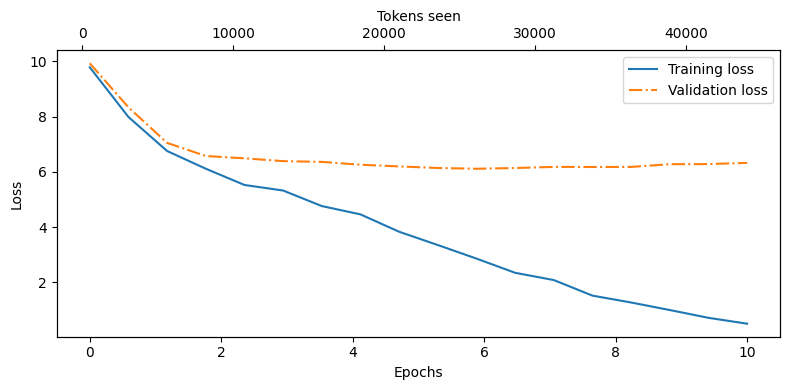

In [32]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Decoding Strategies to Control Randomness